##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#  Functional API のガイド

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/guide/keras/functional"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/guide/keras/functional.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/guide/keras/functional.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/guide/keras/functional.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a>   </td>
</table>

## セットアップ

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-01-11 19:55:31.403237: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 19:55:31.403283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 19:55:31.404886: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 前書き

Keras *Functional API* は、`tf.keras.Sequential` API よりも柔軟なモデルの作成が可能で、非線形トポロジー、共有レイヤー、さらには複数の入力または出力を持つモデル処理することができます。

これは、ディープラーニングのモデルは通常、レイヤーの有向非巡回グラフ（DAG）であるという考えに基づいてます。要するに、Functional API は*レイヤーのグラフ*を構築する方法です。

次のモデルを考察してみましょう。

```
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: logits of a probability distribution over 10 classes)
```

これは 3つ のレイヤーを持つ単純なグラフです。Functional API を使用してモデルを構築するために、まずは入力ノードを作成することから始めます。

In [3]:
inputs = keras.Input(shape=(784,))

データの形状は、784次元のベクトルとして設定されます。各サンプルの形状のみを指定するため、バッチサイズは常に省略されます。

例えば、`(32, 32, 3)`という形状の画像入力がある場合には、次を使用します。

In [4]:
# Just for demonstration purposes.
img_inputs = keras.Input(shape=(32, 32, 3))

返される`inputs`には、モデルに供給する入力データの形状と`dtype`についての情報を含みます。形状は次のとおりです。

In [5]:
inputs.shape

TensorShape([None, 784])

dtype は次のとおりです。

In [6]:
inputs.dtype

tf.float32

この`inputs`オブジェクトのレイヤーを呼び出して、レイヤーのグラフに新しいノードを作成します。

In [7]:
dense = layers.Dense(64, activation="relu")
x = dense(inputs)

「レイヤー呼び出し」アクションは、「入力」から作成したこのレイヤーまで矢印を描くようなものです。`dense`レイヤーに入力を「渡して」、`x`を取得します。

レイヤーのグラフにあと少しレイヤーを追加してみましょう。

In [8]:
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)

この時点で、レイヤーのグラフの入力と出力を指定することにより、`Model`を作成できます。

In [9]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

モデルの概要がどのようなものか、確認しましょう。

In [10]:
model.summary()

Model: "mnist_model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 784)]             0         


 dense (Dense)               (None, 64)                50240     


 dense_1 (Dense)             (None, 64)                4160      


 dense_2 (Dense)             (None, 10)                650       


Total params: 55050 (215.04 KB)


Trainable params: 55050 (215.04 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


また、モデルをグラフとしてプロットすることも可能です。

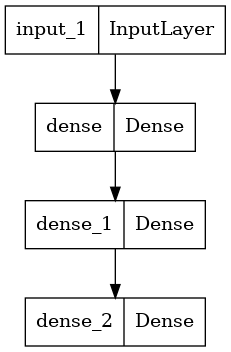

In [11]:
keras.utils.plot_model(model, "my_first_model.png")

そしてオプションで、プロットされたグラフに各レイヤーの入力形状と出力形状を表示します 。

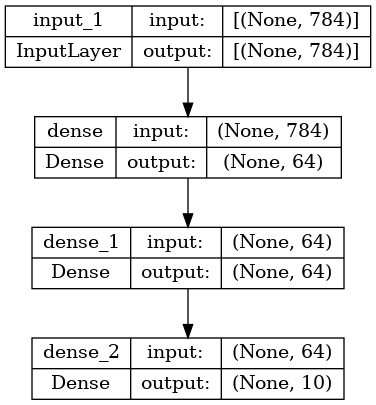

In [12]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

この図とコードはほぼ同じです。コードバージョンでは、接続矢印は呼び出し演算に置き換えられています。

「レイヤーのグラフ」はディープラーニングモデルの直感的なメンタルイメージであり、Functional API はこのメンタルイメージを忠実に映すモデルを作成する方法です。

## トレーニング、評価、推論

Functional API を使用して構築されたモデルの学習、評価、推論は、`Sequential`モデルの場合とまったく同じように動作します。

`Model` クラスにはトレーニングループ（`fit()` メソッド）と評価ループ（`evaluate()` メソッド）が組み込まれています。[これらのループをカスタマイズ](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/)することで、教師あり学習を超えるトレーニングのルーチン（[GAN](/examples/generative/dcgan_overriding_train_step/) など）を簡単に実装することができます。

ここでは、MNIST 画像データを読み込み、ベクトルに再形成し、（検証分割のパフォーマンスを監視しながら）データ上でモデルを当てはめ、その後、テストデータ上でモデルを評価します。

In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/2


I0000 00:00:1705002937.522982  228716 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/750 [..............................] - ETA: 13:07 - loss: 2.4067 - accuracy: 0.1094

 22/750 [..............................] - ETA: 1s - loss: 1.6874 - accuracy: 0.5135   

 44/750 [>.............................] - ETA: 1s - loss: 1.2639 - accuracy: 0.6580

 66/750 [=>............................] - ETA: 1s - loss: 1.0295 - accuracy: 0.7275

 88/750 [==>...........................] - ETA: 1s - loss: 0.8896 - accuracy: 0.7644

110/750 [===>..........................] - ETA: 1s - loss: 0.7946 - accuracy: 0.7872

131/750 [====>.........................] - ETA: 1s - loss: 0.7318 - accuracy: 0.8031

153/750 [=====>........................] - ETA: 1s - loss: 0.6854 - accuracy: 0.8153

174/750 [=====>........................] - ETA: 1s - loss: 0.6483 - accuracy: 0.8248

195/750 [======>.......................] - ETA: 1s - loss: 0.6147 - accuracy: 0.8325

216/750 [=======>......................] - ETA: 1s - loss: 0.5865 - accuracy: 0.8392

237/750 [========>.....................] - ETA: 1s - loss: 0.5645 - accuracy: 0.8439

259/750 [=========>....................] - ETA: 1s - loss: 0.5411 - accuracy: 0.8495

281/750 [==========>...................] - ETA: 1s - loss: 0.5252 - accuracy: 0.8541

303/750 [===========>..................] - ETA: 1s - loss: 0.5064 - accuracy: 0.8593

325/750 [============>.................] - ETA: 1s - loss: 0.4915 - accuracy: 0.8638

347/750 [============>.................] - ETA: 0s - loss: 0.4752 - accuracy: 0.8680

369/750 [=============>................] - ETA: 0s - loss: 0.4638 - accuracy: 0.8709

391/750 [==============>...............] - ETA: 0s - loss: 0.4511 - accuracy: 0.8744

413/750 [===============>..............] - ETA: 0s - loss: 0.4412 - accuracy: 0.8770

436/750 [================>.............] - ETA: 0s - loss: 0.4317 - accuracy: 0.8796

458/750 [=================>............] - ETA: 0s - loss: 0.4227 - accuracy: 0.8821

480/750 [==================>...........] - ETA: 0s - loss: 0.4151 - accuracy: 0.8842

502/750 [===================>..........] - ETA: 0s - loss: 0.4070 - accuracy: 0.8863

524/750 [===================>..........] - ETA: 0s - loss: 0.3982 - accuracy: 0.8889

545/750 [====================>.........] - ETA: 0s - loss: 0.3924 - accuracy: 0.8907

565/750 [=====================>........] - ETA: 0s - loss: 0.3867 - accuracy: 0.8921

586/750 [======================>.......] - ETA: 0s - loss: 0.3799 - accuracy: 0.8938

607/750 [=======================>......] - ETA: 0s - loss: 0.3748 - accuracy: 0.8952

629/750 [========================>.....] - ETA: 0s - loss: 0.3713 - accuracy: 0.8959

650/750 [=========================>....] - ETA: 0s - loss: 0.3663 - accuracy: 0.8974

672/750 [=========================>....] - ETA: 0s - loss: 0.3609 - accuracy: 0.8988

694/750 [==========================>...] - ETA: 0s - loss: 0.3565 - accuracy: 0.9000

717/750 [===========================>..] - ETA: 0s - loss: 0.3509 - accuracy: 0.9014

739/750 [============================>.] - ETA: 0s - loss: 0.3462 - accuracy: 0.9024

750/750 [==============================] - 3s 3ms/step - loss: 0.3431 - accuracy: 0.9034 - val_loss: 0.1855 - val_accuracy: 0.9453


Epoch 2/2


  1/750 [..............................] - ETA: 2s - loss: 0.1838 - accuracy: 0.9375

 23/750 [..............................] - ETA: 1s - loss: 0.2037 - accuracy: 0.9470

 45/750 [>.............................] - ETA: 1s - loss: 0.1798 - accuracy: 0.9486

 67/750 [=>............................] - ETA: 1s - loss: 0.1814 - accuracy: 0.9471

 89/750 [==>...........................] - ETA: 1s - loss: 0.1733 - accuracy: 0.9496

111/750 [===>..........................] - ETA: 1s - loss: 0.1722 - accuracy: 0.9506

132/750 [====>.........................] - ETA: 1s - loss: 0.1680 - accuracy: 0.9519

154/750 [=====>........................] - ETA: 1s - loss: 0.1676 - accuracy: 0.9525

176/750 [======>.......................] - ETA: 1s - loss: 0.1666 - accuracy: 0.9527

198/750 [======>.......................] - ETA: 1s - loss: 0.1673 - accuracy: 0.9523

220/750 [=======>......................] - ETA: 1s - loss: 0.1631 - accuracy: 0.9529

242/750 [========>.....................] - ETA: 1s - loss: 0.1633 - accuracy: 0.9531

264/750 [=========>....................] - ETA: 1s - loss: 0.1664 - accuracy: 0.9524

286/750 [==========>...................] - ETA: 1s - loss: 0.1661 - accuracy: 0.9526

308/750 [===========>..................] - ETA: 1s - loss: 0.1649 - accuracy: 0.9528

331/750 [============>.................] - ETA: 0s - loss: 0.1676 - accuracy: 0.9520

353/750 [=============>................] - ETA: 0s - loss: 0.1658 - accuracy: 0.9525

374/750 [=============>................] - ETA: 0s - loss: 0.1652 - accuracy: 0.9530

396/750 [==============>...............] - ETA: 0s - loss: 0.1646 - accuracy: 0.9532

418/750 [===============>..............] - ETA: 0s - loss: 0.1638 - accuracy: 0.9532

440/750 [================>.............] - ETA: 0s - loss: 0.1628 - accuracy: 0.9534

462/750 [=================>............] - ETA: 0s - loss: 0.1620 - accuracy: 0.9535

484/750 [==================>...........] - ETA: 0s - loss: 0.1613 - accuracy: 0.9534

506/750 [===================>..........] - ETA: 0s - loss: 0.1607 - accuracy: 0.9537

527/750 [====================>.........] - ETA: 0s - loss: 0.1604 - accuracy: 0.9539

548/750 [====================>.........] - ETA: 0s - loss: 0.1604 - accuracy: 0.9540

570/750 [=====================>........] - ETA: 0s - loss: 0.1600 - accuracy: 0.9540

592/750 [======================>.......] - ETA: 0s - loss: 0.1594 - accuracy: 0.9541

614/750 [=======================>......] - ETA: 0s - loss: 0.1582 - accuracy: 0.9543

636/750 [========================>.....] - ETA: 0s - loss: 0.1570 - accuracy: 0.9545

658/750 [=========================>....] - ETA: 0s - loss: 0.1571 - accuracy: 0.9544

680/750 [==========================>...] - ETA: 0s - loss: 0.1570 - accuracy: 0.9544

702/750 [===========================>..] - ETA: 0s - loss: 0.1561 - accuracy: 0.9545

725/750 [============================>.] - ETA: 0s - loss: 0.1556 - accuracy: 0.9547

747/750 [============================>.] - ETA: 0s - loss: 0.1556 - accuracy: 0.9547

750/750 [==============================] - 2s 3ms/step - loss: 0.1553 - accuracy: 0.9548 - val_loss: 0.1380 - val_accuracy: 0.9601


313/313 - 0s - loss: 0.1356 - accuracy: 0.9592 - 489ms/epoch - 2ms/step


Test loss: 0.1356341540813446
Test accuracy: 0.9592000246047974


さらに詳しくは[トレーニングと評価](https://www.tensorflow.org/guide/keras/train_and_evaluate/)ガイドをご覧ください。

## 保存とシリアライズ

Functional API を使用して構築されたモデルの保存とシリアル化は、`Sequential`のモデルと同じように動作します。Functional モデルを保存する標準的な方法は、`model.save()`を呼び出して、モデル全体を単一のファイルとして保存します。モデルを作成したコードが使用できなくなったとしても、後でこのファイルから同じモデルを再作成することが可能です。

保存されたファイルには次を含みます。

- モデルのアーキテクチャ
- モデルの重み値（トレーニングの間に学習された値）
- ある場合は、モデルトレーニング構成（`compile` に渡される構成)
- あれば、オプティマイザとその状態（中断した所からトレーニングを再開するため）

In [14]:
model.save("path_to_my_model")
del model
# Recreate the exact same model purely from the file:
model = keras.models.load_model("path_to_my_model")

INFO:tensorflow:Assets written to: path_to_my_model/assets


INFO:tensorflow:Assets written to: path_to_my_model/assets


詳細は、モデル[シリアライゼーションと保存](https://www.tensorflow.org/guide/keras/save_and_serialize/)ガイドをご覧ください。

## レイヤー群の同じグラフを使用してマルチモデルを定義する

Functional API では、モデルはレイヤー群のグラフでそれらの出入力を指定することにより生成されます。それはレイヤー群の単一のグラフ が複数のモデルを生成するために使用できることを意味しています。

次の例では、レイヤー群の同じスタックを使用して 2 つのモデルのインスタンス化を行います。これらは画像入力を 16 次元ベクトルに変換する`encoder`モデルと、トレーニングのためのエンドツーエンド`autoencoder`モデルです。

In [15]:
encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "encoder"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 img (InputLayer)            [(None, 28, 28, 1)]       0         


 conv2d (Conv2D)             (None, 26, 26, 16)        160       


 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      


 max_pooling2d (MaxPooling2  (None, 8, 8, 32)          0         


 D)                                                              


 conv2d_2 (Conv2D)           (None, 6, 6, 32)          9248      


 conv2d_3 (Conv2D)           (None, 4, 4, 16)          4624      


 global_max_pooling2d (Glob  (None, 16)                0         


 alMaxPooling2D)                                                 


Total params: 18672 (72.94 KB)


Trainable params: 18672 (72.94 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Model: "autoencoder"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 img (InputLayer)            [(None, 28, 28, 1)]       0         


 conv2d (Conv2D)             (None, 26, 26, 16)        160       


 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      


 max_pooling2d (MaxPooling2  (None, 8, 8, 32)          0         


 D)                                                              


 conv2d_2 (Conv2D)           (None, 6, 6, 32)          9248      


 conv2d_3 (Conv2D)           (None, 4, 4, 16)          4624      


 global_max_pooling2d (Glob  (None, 16)                0         


 alMaxPooling2D)                                                 


 reshape (Reshape)           (None, 4, 4, 1)           0         


 conv2d_transpose (Conv2DTr  (None, 6, 6, 16)          160       


 anspose)                                                        


 conv2d_transpose_1 (Conv2D  (None, 8, 8, 32)          4640      


 Transpose)                                                      


 up_sampling2d (UpSampling2  (None, 24, 24, 32)        0         


 D)                                                              


 conv2d_transpose_2 (Conv2D  (None, 26, 26, 16)        4624      


 Transpose)                                                      


 conv2d_transpose_3 (Conv2D  (None, 28, 28, 1)         145       


 Transpose)                                                      


Total params: 28241 (110.32 KB)


Trainable params: 28241 (110.32 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


ここでは、デコーディングアーキテクチャはエンコーディングアーキテクチャに対して厳密に対称的であるため、出力形状は入力形状`(28, 28, 1)`と同じです。

`Conv2D`レイヤーの反対は`Conv2DTranspose`レイヤーで、`MaxPooling2D`レイヤーの反対は`UpSampling2D`レイヤーです。

## レイヤー同様、全てのモデルは呼び出し可能

任意のモデルを`Input`上、あるいはもう一つのレイヤーの出力上で呼び出すことによって、それがレイヤーであるかのように扱うことができます。モデルを呼び出すことにより、単にモデルのアーキテクチャを再利用しているのではなく、その重みも再利用していることになります。

これを実際に見るために、エンコーダモデルとデコーダモデルを作成し、それらを 2 回の呼び出しに連鎖してオートエンコーダ―モデルを取得する、オートエンコーダの異なる例を次に示します。

In [16]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "encoder"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 original_img (InputLayer)   [(None, 28, 28, 1)]       0         


 conv2d_4 (Conv2D)           (None, 26, 26, 16)        160       


 conv2d_5 (Conv2D)           (None, 24, 24, 32)        4640      


 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         


 g2D)                                                            


 conv2d_6 (Conv2D)           (None, 6, 6, 32)          9248      


 conv2d_7 (Conv2D)           (None, 4, 4, 16)          4624      


 global_max_pooling2d_1 (Gl  (None, 16)                0         


 obalMaxPooling2D)                                               


Total params: 18672 (72.94 KB)


Trainable params: 18672 (72.94 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Model: "decoder"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 encoded_img (InputLayer)    [(None, 16)]              0         


 reshape_1 (Reshape)         (None, 4, 4, 1)           0         


 conv2d_transpose_4 (Conv2D  (None, 6, 6, 16)          160       


 Transpose)                                                      


 conv2d_transpose_5 (Conv2D  (None, 8, 8, 32)          4640      


 Transpose)                                                      


 up_sampling2d_1 (UpSamplin  (None, 24, 24, 32)        0         


 g2D)                                                            


 conv2d_transpose_6 (Conv2D  (None, 26, 26, 16)        4624      


 Transpose)                                                      


 conv2d_transpose_7 (Conv2D  (None, 28, 28, 1)         145       


 Transpose)                                                      


Total params: 9569 (37.38 KB)


Trainable params: 9569 (37.38 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Model: "autoencoder"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 img (InputLayer)            [(None, 28, 28, 1)]       0         


 encoder (Functional)        (None, 16)                18672     


 decoder (Functional)        (None, 28, 28, 1)         9569      


Total params: 28241 (110.32 KB)


Trainable params: 28241 (110.32 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


ご覧のように、モデルはネストすることができ、(モデルはちょうどレイヤーのようなものであるため）サブモデルを含むことができます。モデル・ネスティングのための一般的なユースケースは *アンサンブル* です。モデルのセットを (それらの予測を平均する) 単一のモデルにアンサンブルする方法の例を次に示します。

In [17]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)


model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

## 複雑なグラフトポロジーを操作する

### マルチ入力と出力を持つモデル

Functional API はマルチ入力と出力の操作を容易にします。これは `Sequential` API では処理できません。

たとえば、顧客が発行したチケットを優先度別にランク付けし、正しい部門にルーティングするシステムを構築する場合、モデルには次の 3 つの入力があります。

- チケットの件名 （テキスト入力）
- チケットの本文（テキスト入力）
- ユーザーが追加した任意のタグ（カテゴリ入力）

このモデルには 2 つの出力があります。

- 0 と 1 の間のプライオリティスコア（スカラーシグモイド出力）
- チケットを処理すべき部門（部門集合に渡るソフトマックス出力）

このモデルは Functional API を使用すると数行で構築が可能です。

In [18]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

では、モデルをプロットします。

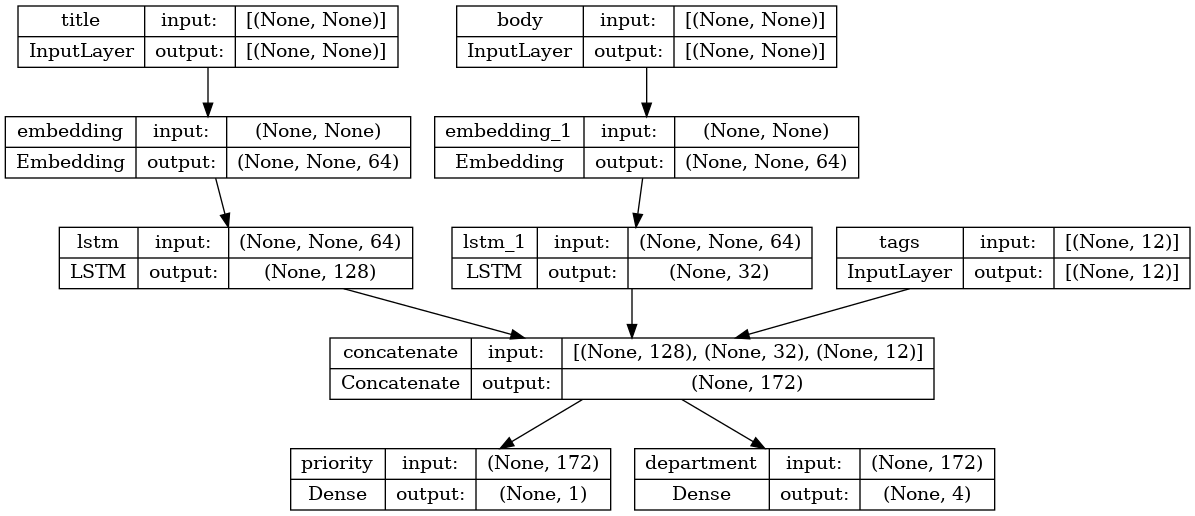

In [19]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

このモデルをコンパイルする時に、各出力に異なる損失を割り当てることができます。また、各損失に異なる重みを割り当てて、トレーニング損失全体へのそれらの寄与をモジュール化することも可能です。

In [20]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)

出力レイヤーの名前が異なるため、対応するレイヤー名を使用して、損失と損失の重みを指定することも可能です。

In [21]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights={"priority": 1.0, "department": 0.2},
)

入力とターゲットの NumPy 配列のリストを渡し、モデルをトレーニングします。

In [22]:
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2


 1/40 [..............................] - ETA: 2:20 - loss: 1.3038 - priority_loss: 0.7109 - department_loss: 2.9643

 2/40 [>.............................] - ETA: 4s - loss: 1.2839 - priority_loss: 0.6998 - department_loss: 2.9203  

 3/40 [=>............................] - ETA: 4s - loss: 1.2639 - priority_loss: 0.6968 - department_loss: 2.8352

 4/40 [==>...........................] - ETA: 3s - loss: 1.2571 - priority_loss: 0.7004 - department_loss: 2.7835

 5/40 [==>...........................] - ETA: 3s - loss: 1.2600 - priority_loss: 0.7007 - department_loss: 2.7962

 6/40 [===>..........................] - ETA: 3s - loss: 1.2675 - priority_loss: 0.6998 - department_loss: 2.8385

 7/40 [====>.........................] - ETA: 3s - loss: 1.2576 - priority_loss: 0.6978 - department_loss: 2.7991

 8/40 [=====>........................] - ETA: 3s - loss: 1.2574 - priority_loss: 0.6990 - department_loss: 2.7922

 9/40 [=====>........................] - ETA: 3s - loss: 1.2534 - priority_loss: 0.6990 - department_loss: 2.7723

10/40 [======>.......................] - ETA: 3s - loss: 1.2499 - priority_loss: 0.7020 - department_loss: 2.7392

11/40 [=======>......................] - ETA: 3s - loss: 1.2475 - priority_loss: 0.7042 - department_loss: 2.7164

12/40 [========>.....................] - ETA: 3s - loss: 1.2461 - priority_loss: 0.7046 - department_loss: 2.7073

13/40 [========>.....................] - ETA: 2s - loss: 1.2509 - priority_loss: 0.7059 - department_loss: 2.7251

14/40 [=========>....................] - ETA: 2s - loss: 1.2510 - priority_loss: 0.7054 - department_loss: 2.7280

16/40 [===========>..................] - ETA: 2s - loss: 1.2559 - priority_loss: 0.7054 - department_loss: 2.7528

17/40 [===========>..................] - ETA: 2s - loss: 1.2538 - priority_loss: 0.7051 - department_loss: 2.7434

18/40 [============>.................] - ETA: 2s - loss: 1.2579 - priority_loss: 0.7047 - department_loss: 2.7660

19/40 [=============>................] - ETA: 2s - loss: 1.2569 - priority_loss: 0.7034 - department_loss: 2.7675

20/40 [==============>...............] - ETA: 2s - loss: 1.2604 - priority_loss: 0.7027 - department_loss: 2.7883

21/40 [==============>...............] - ETA: 1s - loss: 1.2596 - priority_loss: 0.7028 - department_loss: 2.7843

22/40 [===============>..............] - ETA: 1s - loss: 1.2638 - priority_loss: 0.7045 - department_loss: 2.7965

23/40 [================>.............] - ETA: 1s - loss: 1.2611 - priority_loss: 0.7045 - department_loss: 2.7832

24/40 [=================>............] - ETA: 1s - loss: 1.2585 - priority_loss: 0.7047 - department_loss: 2.7689

25/40 [=================>............] - ETA: 1s - loss: 1.2565 - priority_loss: 0.7052 - department_loss: 2.7568

26/40 [==================>...........] - ETA: 1s - loss: 1.2559 - priority_loss: 0.7056 - department_loss: 2.7515

29/40 [====================>.........] - ETA: 1s - loss: 1.2646 - priority_loss: 0.7064 - department_loss: 2.7909

30/40 [=====================>........] - ETA: 0s - loss: 1.2689 - priority_loss: 0.7064 - department_loss: 2.8124

31/40 [======================>.......] - ETA: 0s - loss: 1.2743 - priority_loss: 0.7080 - department_loss: 2.8313

33/40 [=======================>......] - ETA: 0s - loss: 1.2731 - priority_loss: 0.7084 - department_loss: 2.8238

34/40 [========================>.....] - ETA: 0s - loss: 1.2720 - priority_loss: 0.7080 - department_loss: 2.8202

36/40 [==========================>...] - ETA: 0s - loss: 1.2770 - priority_loss: 0.7069 - department_loss: 2.8505

38/40 [===========================>..] - ETA: 0s - loss: 1.2799 - priority_loss: 0.7071 - department_loss: 2.8642

40/40 [==============================] - 7s 88ms/step - loss: 1.2841 - priority_loss: 0.7063 - department_loss: 2.8890


Epoch 2/2


 1/40 [..............................] - ETA: 4s - loss: 1.2308 - priority_loss: 0.7145 - department_loss: 2.5812

 3/40 [=>............................] - ETA: 2s - loss: 1.2948 - priority_loss: 0.7052 - department_loss: 2.9483

 7/40 [====>.........................] - ETA: 1s - loss: 1.2832 - priority_loss: 0.6987 - department_loss: 2.9227

 8/40 [=====>........................] - ETA: 1s - loss: 1.2902 - priority_loss: 0.6980 - department_loss: 2.9611

12/40 [========>.....................] - ETA: 1s - loss: 1.2793 - priority_loss: 0.6974 - department_loss: 2.9093

18/40 [============>.................] - ETA: 0s - loss: 1.2863 - priority_loss: 0.7009 - department_loss: 2.9270

19/40 [=============>................] - ETA: 0s - loss: 1.2866 - priority_loss: 0.7001 - department_loss: 2.9326

23/40 [================>.............] - ETA: 0s - loss: 1.2948 - priority_loss: 0.7032 - department_loss: 2.9579

26/40 [==================>...........] - ETA: 0s - loss: 1.2956 - priority_loss: 0.7040 - department_loss: 2.9579

27/40 [===================>..........] - ETA: 0s - loss: 1.2975 - priority_loss: 0.7033 - department_loss: 2.9710

33/40 [=======================>......] - ETA: 0s - loss: 1.2998 - priority_loss: 0.7034 - department_loss: 2.9816

34/40 [========================>.....] - ETA: 0s - loss: 1.3007 - priority_loss: 0.7043 - department_loss: 2.9818

35/40 [=========================>....] - ETA: 0s - loss: 1.2993 - priority_loss: 0.7040 - department_loss: 2.9764

39/40 [============================>.] - ETA: 0s - loss: 1.3002 - priority_loss: 0.7040 - department_loss: 2.9810

40/40 [==============================] - 2s 39ms/step - loss: 1.3025 - priority_loss: 0.7044 - department_loss: 2.9903


`Dataset`オブジェクトで fit を呼び出す時、それは`([title_data, body_data, tags_data], [priority_targets, dept_targets])`などのリストのタプル、または`({'title': title_data, 'body': body_data, 'tags': tags_data}、{'priority': priority_targets, 'department': dept_targets})`などのディクショナリのタプルを yield する必要があります。

さらに詳しい説明については、[トレーニングと評価](https://www.tensorflow.org/guide/keras/train_and_evaluate/)ガイドをご覧ください。

### トイ ResNet モデル

複数の入力と出力を持つモデルに加えて、Functional API では非線形接続トポロジー、つまりシーケンシャルに接続されていないレイヤーを持つモデルの操作を容易にします。これは`Sequential` API では扱うことができません。

これの一般的なユースケースは、残差接続です。これを実証するために、CIFAR10 向けのトイ ResNet モデルを構築してみましょう。

In [23]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Model: "toy_resnet"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 img (InputLayer)            [(None, 32, 32, 3)]          0         []                            


 conv2d_8 (Conv2D)           (None, 30, 30, 32)           896       ['img[0][0]']                 


 conv2d_9 (Conv2D)           (None, 28, 28, 64)           18496     ['conv2d_8[0][0]']            


 max_pooling2d_2 (MaxPoolin  (None, 9, 9, 64)             0         ['conv2d_9[0][0]']            


 g2D)                                                                                             


 conv2d_10 (Conv2D)          (None, 9, 9, 64)             36928     ['max_pooling2d_2[0][0]']     


 conv2d_11 (Conv2D)          (None, 9, 9, 64)             36928     ['conv2d_10[0][0]']           


 add (Add)                   (None, 9, 9, 64)             0         ['conv2d_11[0][0]',           


                                                                     'max_pooling2d_2[0][0]']     


 conv2d_12 (Conv2D)          (None, 9, 9, 64)             36928     ['add[0][0]']                 


 conv2d_13 (Conv2D)          (None, 9, 9, 64)             36928     ['conv2d_12[0][0]']           


 add_1 (Add)                 (None, 9, 9, 64)             0         ['conv2d_13[0][0]',           


                                                                     'add[0][0]']                 


 conv2d_14 (Conv2D)          (None, 7, 7, 64)             36928     ['add_1[0][0]']               


 global_average_pooling2d (  (None, 64)                   0         ['conv2d_14[0][0]']           


 GlobalAveragePooling2D)                                                                          


 dense_6 (Dense)             (None, 256)                  16640     ['global_average_pooling2d[0][


                                                                    0]']                          


 dropout (Dropout)           (None, 256)                  0         ['dense_6[0][0]']             


 dense_7 (Dense)             (None, 10)                   2570      ['dropout[0][0]']             


Total params: 223242 (872.04 KB)


Trainable params: 223242 (872.04 KB)


Non-trainable params: 0 (0.00 Byte)


__________________________________________________________________________________________________


モデルをプロットします。

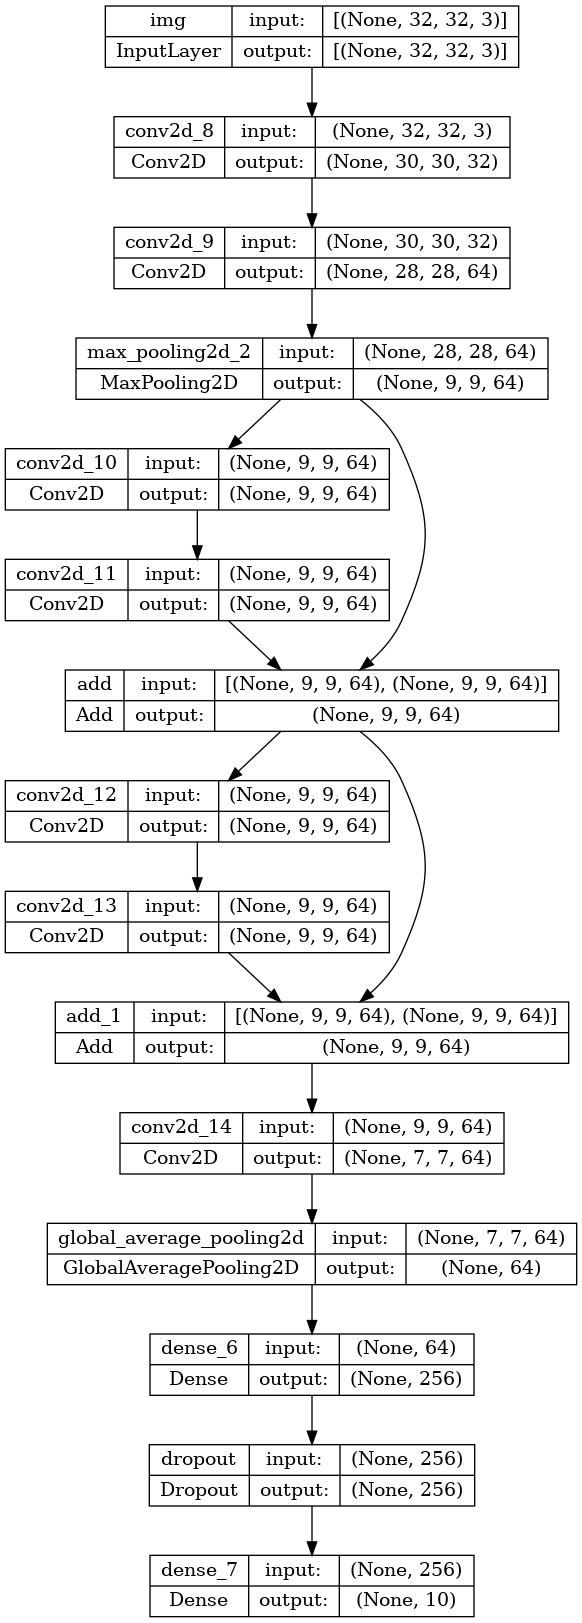

In [24]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

モデルをトレーニングします。

In [25]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)
# We restrict the data to the first 1000 samples so as to limit execution time
# on Colab. Try to train on the entire dataset until convergence!
model.fit(x_train[:1000], y_train[:1000], batch_size=64, epochs=1, validation_split=0.2)

     8192/170498071 [..............................] - ETA: 0s

   196608/170498071 [..............................] - ETA: 57s

  1490944/170498071 [..............................] - ETA: 13s

  4554752/170498071 [..............................] - ETA: 6s 

  8822784/170498071 [>.............................] - ETA: 3s

 13156352/170498071 [=>............................] - ETA: 3s

 18923520/170498071 [==>...........................] - ETA: 2s

 24600576/170498071 [===>..........................] - ETA: 2s

 29335552/170498071 [====>.........................] - ETA: 2s

 33710080/170498071 [====>.........................] - ETA: 1s

 38912000/170498071 [=====>........................] - ETA: 1s

 44703744/170498071 [======>.......................] - ETA: 1s

 50077696/170498071 [=======>......................] - ETA: 1s

 54419456/170498071 [========>.....................] - ETA: 1s

 58826752/170498071 [=========>....................] - ETA: 1s

 64618496/170498071 [==========>...................] - ETA: 1s

 70238208/170498071 [===========>..................] - ETA: 1s

 74801152/170498071 [============>.................] - ETA: 1s

 79151104/170498071 [============>.................] - ETA: 1s

 84516864/170498071 [=============>................] - ETA: 0s

 90243072/170498071 [==============>...............] - ETA: 0s

 95281152/170498071 [===============>..............] - ETA: 0s

 99672064/170498071 [================>.............] - ETA: 0s

104587264/170498071 [=================>............] - ETA: 0s

110288896/170498071 [==================>...........] - ETA: 0s

115720192/170498071 [===================>..........] - ETA: 0s

120070144/170498071 [====================>.........] - ETA: 0s

124485632/170498071 [====================>.........] - ETA: 0s

130203648/170498071 [=====================>........] - ETA: 0s

135905280/170498071 [======================>.......] - ETA: 0s

140361728/170498071 [=======================>......] - ETA: 0s

144752640/170498071 [========================>.....] - ETA: 0s

150315008/170498071 [=========================>....] - ETA: 0s

155959296/170498071 [==========================>...] - ETA: 0s

160743424/170498071 [===========================>..] - ETA: 0s

165068800/170498071 [============================>.] - ETA: 0s

170262528/170498071 [============================>.] - ETA: 0s

170498071/170498071 [==============================] - 2s 0us/step


 1/13 [=>............................] - ETA: 40s - loss: 2.3051 - acc: 0.1094

 7/13 [===============>..............] - ETA: 0s - loss: 2.3104 - acc: 0.0871 

13/13 [==============================] - ETA: 0s - loss: 2.3002 - acc: 0.1050

13/13 [==============================] - 4s 80ms/step - loss: 2.3002 - acc: 0.1050 - val_loss: 2.2924 - val_acc: 0.1050


## レイヤーを共有する

Functional API のもう 1 つの良い使い方は、*共有レイヤー*を使用するモデルです。共有レイヤーは、同じモデルで複数回再利用されるレイヤーインスタンスのことで、レイヤーグラフ内の複数のパスに対応するフィーチャを学習します。

共有レイヤーは、似たような空間からの入力（例えば、似た語彙を特徴とする 2 つの異なるテキスト）をエンコードするためにしばしば使用されます。これにより、それら異なる入力間での情報の共有を可能になり、より少ないデータでそのようなモデルをトレーニングすることが可能になります。与えられた単語が入力のいずれかに見られる場合、それは共有レイヤーを通過する全ての入力の処理に有用です。

Functional API でレイヤーを共有するには、同じレイヤーインスタンスを複数回呼び出します。例えば、2 つの異なるテキスト入力間で共有される `Embedding` レイヤを以下に示します。

In [26]:
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

# Variable-length sequence of integers
text_input_a = keras.Input(shape=(None,), dtype="int32")

# Variable-length sequence of integers
text_input_b = keras.Input(shape=(None,), dtype="int32")

# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

## レイヤーのグラフのノードを抽出して再利用する

操作しているレイヤーのグラフは静的なデータ構造であるため、アクセスして検査をすることができます。そして、これが関数型モデルを画像としてプロットする方法でもあります。

これはまた、中間レイヤー（グラフ内の「ノード」）のアクティブ化にアクセスが可能で、他の場所で再利用できることを意味します。これは特徴抽出などに非常に便利です。

例を見てみましょう。これは ImageNet 上で事前トレーニングされた、重みを持つ VGG19 モデルです。

In [27]:
vgg19 = tf.keras.applications.VGG19()

     8192/574710816 [..............................] - ETA: 0s

  4202496/574710816 [..............................] - ETA: 9s

 18710528/574710816 [..............................] - ETA: 3s

 33234944/574710816 [>.............................] - ETA: 2s

 43204608/574710816 [=>............................] - ETA: 2s

 58908672/574710816 [==>...........................] - ETA: 2s

 75104256/574710816 [==>...........................] - ETA: 2s

 89071616/574710816 [===>..........................] - ETA: 2s

100671488/574710816 [====>.........................] - ETA: 2s

115875840/574710816 [=====>........................] - ETA: 1s

129581056/574710816 [=====>........................] - ETA: 1s

143704064/574710816 [======>.......................] - ETA: 1s

156966912/574710816 [=======>......................] - ETA: 1s

172400640/574710816 [=======>......................] - ETA: 1s

185131008/574710816 [========>.....................] - ETA: 1s

201342976/574710816 [=========>....................] - ETA: 1s

216932352/574710816 [==========>...................] - ETA: 1s

231055360/574710816 [===========>..................] - ETA: 1s

240615424/574710816 [===========>..................] - ETA: 1s

256860160/574710816 [============>.................] - ETA: 1s

269819904/574710816 [=============>................] - ETA: 1s

283402240/574710816 [=============>................] - ETA: 1s

298541056/574710816 [==============>...............] - ETA: 1s

313147392/574710816 [===============>..............] - ETA: 1s

327417856/574710816 [================>.............] - ETA: 0s

342786048/574710816 [================>.............] - ETA: 0s

358621184/574710816 [=================>............] - ETA: 0s

374259712/574710816 [==================>...........] - ETA: 0s

386023424/574710816 [===================>..........] - ETA: 0s

401178624/574710816 [===================>..........] - ETA: 0s

416497664/574710816 [====================>.........] - ETA: 0s

430178304/574710816 [=====================>........] - ETA: 0s

445038592/574710816 [======================>.......] - ETA: 0s

460242944/574710816 [=======================>......] - ETA: 0s

469843968/574710816 [=======================>......] - ETA: 0s

486424576/574710816 [========================>.....] - ETA: 0s

501874688/574710816 [=========================>....] - ETA: 0s

517488640/574710816 [==========================>...] - ETA: 0s

533618688/574710816 [==========================>...] - ETA: 0s

550158336/574710816 [===========================>..] - ETA: 0s

565215232/574710816 [============================>.] - ETA: 0s

574710816/574710816 [==============================] - 2s 0us/step


そしてこれらはグラフデータ構造をクエリして得られる、モデルの中間的なアクティブ化です。

In [28]:
features_list = [layer.output for layer in vgg19.layers]

これらの機能を使用して、中間レイヤーのアクティブ化の値を返す新しい特徴抽出モデルを作成します。

In [29]:
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype("float32")
extracted_features = feat_extraction_model(img)

これは特に、[ニューラルスタイル転送](https://keras.io/examples/generative/neural_style_transfer/)などのタスクに有用です。

## カスタム層を使用して API を拡張する

`tf.keras`には、例えば、次のような幅広い組み込みレイヤーが含まれています。

- 畳み込みレイヤー : `Conv1D`、`Conv2D`、`Conv3D`、`Conv2DTranspose`
- Pooling レイヤー : `MaxPooling1D`、`MaxPooling2D`、`MaxPooling3D`、`AveragePooling1D`
- RNN レイヤー : `GRU`、`LSTM`、`ConvLSTM2D`
- `BatchNormalization`、`Dropout`、`Embedding`、など

必要なものが見つからない場合は、独自のレイヤーを作成して容易に API を拡張することができます。すべてのレイヤーは`Layer`クラスをサブクラス化して実装します。

- `call`メソッドは、レイヤーが行う計算を指定します。
- `build`メソッドは、レイヤーの重みを作成します（`__init__`でも重みを作成できるため、これは単なるスタイル慣習です）。

レイヤーの新規作成に関する詳細については、[カスタムレイヤーとモデル](https://www.tensorflow.org/guide/keras/custom_layers_and_models)ガイドをご覧ください。

`tf.keras.layers.Dense`の基本的な実装を以下に示します。

In [30]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)

カスタムレイヤーでシリアル化をサポートするには、レイヤーインスタンスのコンストラクタ引数を返す `get_config` メソッドを定義します。

In [31]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)
config = model.get_config()

new_model = keras.Model.from_config(config, custom_objects={"CustomDense": CustomDense})

オプションで、config ディクショナリが与えられたレイヤーインスタンスを再作成する際に使用されたクラスメソッド `from_config(cls, config)` を実装します。デフォルトの `from_config` の実装は以下の通りです。

```python
def from_config(cls, config):
  return cls(**config)
```

## いつ Functional API を使用するか

新しいモデルを作成する場合または `Model`クラスを直接サブクラス化する場合に、Keras Functional API を使用する必要があるのでしょうか？ 一般的に Functional API はより高レベル、より容易かつ安全で、サブクラス化されたモデルがサポートしない多くの特徴を持っています。

ただし、レイヤーの有向非巡回グラフ（DAG）として容易に表現できないモデルを構築する場合には、モデルのサブクラス化がより大きな柔軟性を与えます。例えば、Functional API では Tree-RNN を実装できず、`Model`を直接サブクラス化する必要があります。

Functional API とモデルのサブクラス化の違いに関する詳細については、[TensorFlow 2.0 における Symbolic API と Imperative API とは？](https://blog.tensorflow.org/2019/01/what-are-symbolic-and-imperative-apis.html)をご覧ください。

### Functional API の長所 :

以下のプロパティは、（データ構造体でもある）Sequential モデルには真であり、（Python のバイトコードであり、データ構造体ではない）サブクラス化されたモデルには真ではありません。

#### 低い冗長性

`super(MyClass, self).__init__(...)`、`def call(self, ...):`などがありません。

比較しよう :

```python
inputs = keras.Input(shape=(32,))
x = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10)(x)
mlp = keras.Model(inputs, outputs)
```

サブクラス化されたバージョンと比べます。

```python
class MLP(keras.Model):

  def __init__(self, **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.dense_1 = layers.Dense(64, activation='relu')
    self.dense_2 = layers.Dense(10)

  def call(self, inputs):
    x = self.dense_1(inputs)
    return self.dense_2(x)

# Instantiate the model.
mlp = MLP()
# Necessary to create the model's state.
# The model doesn't have a state until it's called at least once.
_ = mlp(tf.zeros((1, 32)))
```

#### 連結グラフを定義しながらモデルを検証する

Functional API では、入力仕様（形状とdtype）が（`Input`を使用して）あらかじめ作成されています。レイヤーを呼び出すたびに、レイヤーは渡された仕様が想定と一致しているかどうかをチェックし、一致していない場合には有用なエラーメッセージを表示します。

これにより、Functional API を使用して構築できるモデルは全て確実に実行されます。収束関連のデバッグ以外の全てのデバッグは、実行時ではなく、モデル構築中に静的に行われます。これはコンパイラの型チェックに類似しています。

#### 関数型モデルはプロット可能かつ検査可能です

モデルをグラフとしてプロットすることが可能で、このグラフの中間ノードに簡単にアクセスすることができます。例えば（前の例で示したように）中間レイヤーのアクティブ化を抽出して再利用します。

```python
features_list = [layer.output for layer in vgg19.layers]
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)
```

#### 関数型モデルは、シリアル化やクローン化が可能です

関数型モデルはコードの一部ではなくデータ構造であるため、安全なシリアル化が可能です。また、単一のファイルとして保存できるため、元のコードにアクセスすることなく全く同じモデルを再作成することができます。詳細は[シリアル化と保存に関するガイド](https://www.tensorflow.org/guide/keras/save_and_serialize/)をご覧ください。

サブクラス化されたモデルをシリアライズするには、実装者がモデルレベルで`get_config()`および`from_config()`メソッドを指定する必要があります。

### Functional API の弱点 :

#### 動的アーキテクチャをサポートしません

Functional API は、モデルをレイヤーの DAG として扱います。これはほとんどのディープラーニングアーキテクチャでは真ですが、必ずしも全てのアーキテクチャに該当するわけではありません。例えば、再帰的ネットワークや Tree RNN はこの想定に従わないため、Functional API では実装できません。

## 異なる API スタイルをうまく組み合わせる

Functional API とモデルのサブクラス化のいずれかを選択することは、モデルの 1 つのカテゴリに制限する二者択一ではありません。`tf.keras` API 内の全てのモデルは、それらが`Sequential` モデルでも、関数型モデルでも、新規に書かれたサブクラス化されたモデルであっても、お互いに相互作用することができます。

関数型モデルや`Sequential`モデルは、サブクラス化されたモデルやレイヤーの一部として常に使用することができます。

In [32]:
units = 32
timesteps = 10
input_dim = 5

# Define a Functional model
inputs = keras.Input((None, units))
x = layers.GlobalAveragePooling1D()(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        # Our previously-defined Functional model
        self.classifier = model

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        print(features.shape)
        return self.classifier(features)


rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, timesteps, input_dim)))

(1, 10, 32)


次のいずれかのパターンに従った`call`メソッドを実装していれば、Functional API で任意のサブクラス化されたレイヤーやモデルを使用することができます。

- `call(self, inputs, **kwargs)` -- ここでいう`inputs`は、テンソルまたはテンソルのネストされた構造（テンソルのリストなど）であり、`**kwargs`は非テンソルの引数（非 inputs）です。
- `call(self, inputs, training=None, **kwargs)` -- この`training` は、レイヤーがトレーニングモードと推論モードで振る舞うべきかどうかを示すブールです。
- `call(self, inputs, mask=None, **kwargs)` -- この`mask`は、ブールマスクテンソルです。（例えば RNNに便利です。）
- `call(self, inputs, training=None, mask=None, **kwargs)` -- もちろん、マスキングとトレーニング固有の動作の両方を同時に持つことができます。

さらに、カスタムレイヤーやモデルで`get_config`メソッドを実装する場合、作成した関数型モデルは依然としてシリアル化やクローン化が可能です。

新規に書かれたカスタム RNN を関数型モデルで使用する簡単な例を以下に示します。

In [33]:
units = 32
timesteps = 10
input_dim = 5
batch_size = 16


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        self.classifier = layers.Dense(1)

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        return self.classifier(features)


# Note that you specify a static batch size for the inputs with the `batch_shape`
# arg, because the inner computation of `CustomRNN` requires a static batch size
# (when you create the `state` zeros tensor).
inputs = keras.Input(batch_shape=(batch_size, timesteps, input_dim))
x = layers.Conv1D(32, 3)(inputs)
outputs = CustomRNN()(x)

model = keras.Model(inputs, outputs)

rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, 10, 5)))